In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data

In [2]:
t = np.linspace(0, 2*np.pi, 40, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

In [3]:
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

# Mesh 

In [4]:
cndt = triangulate({'vertices':points, 'segments':seg}, opts='Rpq30a0.01ne')

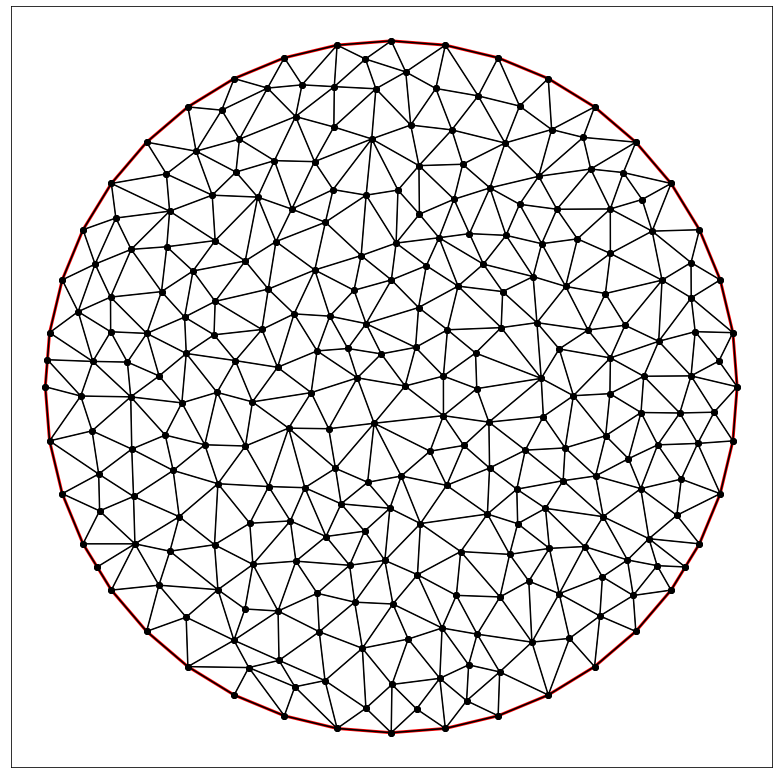

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 14))
ax = plt.subplot(111, aspect='equal')
tplot(ax, **cndt)
# fig.savefig('../images/circle_mesh')
plt.show()

In [6]:
points = cndt['vertices']
triangles = cndt['triangles']
neighbours = cndt['neighbors']
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

In [7]:
tx = np.linspace(-1, 1, 200)
ty = np.linspace(-1, 1, 200)
xx, yy = np.meshgrid(tx, ty, indexing='xy')
points_ = np.stack((xx, yy)).transpose(1, 2, 0)

a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [ ]:
a = (points_[...,] - triangles_s[:, 0, None, None])
b = (points_[...,] - triangles_s[:, 1, None, None])
c = (points_[...,] - triangles_s[:, 2, None, None])

area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])

indices = np.where(np.isclose((area1+area2+area3).transpose(1, 2, 0), areas[None, None, ...]))

## Get boundary points

In [ ]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)

In [ ]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element] = True
    elif (neighbours[index] == -1).sum() == 1:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True

In [ ]:
colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'brown', 'orange', 'olive', 'gold', 'indigo', 'peru', 'maroon']
l = len(colors)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('equal')


for index, triangle in enumerate(triangles_s):
    t1 = plt.Polygon(triangle, color=colors[index%l])
    fig.gca().add_patch(t1)
    
    x, y = triangle.mean(axis=0)
    ax.text(x, y, s=f'{index}', fontsize=10)

for idx, point in enumerate(points):
    ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f'{idx}', fontsize=5)
    
for idx, point in enumerate(points):
    if is_boundary_point[idx]:
        ax.scatter(point[0], point[1], color='black', lw=10, s=2)
    else:
        ax.scatter(point[0], point[1], color='black')
        
fig.tight_layout()
plt.show()

In [ ]:
matrix = np.zeros((points.shape[0], points.shape[0]), dtype=np.float64)
b = np.zeros(points.shape[0])
f = np.ones(points.shape[0]) * 2
# f = c

for idx, element in enumerate(triangles):
        
    if is_boundary_point[element[0]] == True:
        matrix[element[0], element[0]] = 1
        b[element[0]] = 0
    else:

        matrix[element[0], element[0]] += 2 * (points[element[1], 1] - points[element[2], 1])*(points[element[1], 1] - points[element[2], 1]) / areas[idx]
        matrix[element[0], element[1]] += 2 * (points[element[1], 1] - points[element[2], 1])*(points[element[2], 1] - points[element[0], 1]) / areas[idx]
        matrix[element[0], element[2]] += 2 * (points[element[1], 1] - points[element[2], 1])*(points[element[0], 1] - points[element[1], 1]) / areas[idx]

        matrix[element[0], element[0]] += 2 * (points[element[1], 0] - points[element[2], 0])*(points[element[1], 0] - points[element[2], 0]) / areas[idx]
        matrix[element[0], element[1]] += 2 * (points[element[1], 0] - points[element[2], 0])*(points[element[2], 0] - points[element[0], 0]) / areas[idx]
        matrix[element[0], element[2]] += 2 * (points[element[1], 0] - points[element[2], 0])*(points[element[0], 0] - points[element[1], 0]) / areas[idx]

        b[element[0]] -= 2 * areas[idx] / 3 * f[element[0]]

    if is_boundary_point[element[1]] == True:
        matrix[element[1], element[1]] = 1
        b[element[1]] *= 0
    else:

        matrix[element[1], element[0]] += 2 * (points[element[2], 1] - points[element[0], 1])*(points[element[1], 1] - points[element[2], 1]) / areas[idx]
        matrix[element[1], element[1]] += 2 * (points[element[2], 1] - points[element[0], 1])*(points[element[2], 1] - points[element[0], 1]) / areas[idx]
        matrix[element[1], element[2]] += 2 * (points[element[2], 1] - points[element[0], 1])*(points[element[0], 1] - points[element[1], 1]) / areas[idx]

        matrix[element[1], element[0]] += 2 * (points[element[2], 0] - points[element[0], 0])*(points[element[1], 0] - points[element[2], 0]) / areas[idx]
        matrix[element[1], element[1]] += 2 * (points[element[2], 0] - points[element[0], 0])*(points[element[2], 0] - points[element[0], 0]) / areas[idx]
        matrix[element[1], element[2]] += 2 * (points[element[2], 0] - points[element[0], 0])*(points[element[0], 0] - points[element[1], 0]) / areas[idx]

        b[element[1]] -= 2 * areas[idx] / 3 * f[element[0]]

    if is_boundary_point[element[2]] == True:
        matrix[element[2], element[2]] = 1
        b[element[2]] *= 0
    else:
        
        matrix[element[2], element[0]] += 2 * (points[element[0], 1] - points[element[1], 1])*(points[element[1], 1] - points[element[2], 1]) / areas[idx]
        matrix[element[2], element[1]] += 2 * (points[element[0], 1] - points[element[1], 1])*(points[element[2], 1] - points[element[0], 1]) / areas[idx]
        matrix[element[2], element[2]] += 2 * (points[element[0], 1] - points[element[1], 1])*(points[element[0], 1] - points[element[1], 1]) / areas[idx]

        matrix[element[2], element[0]] += 2 * (points[element[0], 0] - points[element[1], 0])*(points[element[1], 0] - points[element[2], 0]) / areas[idx]
        matrix[element[2], element[1]] += 2 * (points[element[0], 0] - points[element[1], 0])*(points[element[2], 0] - points[element[0], 0]) / areas[idx]
        matrix[element[2], element[2]] += 2 * (points[element[0], 0] - points[element[1], 0])*(points[element[0], 0] - points[element[1], 0]) / areas[idx]
    
        b[element[2]] -= 2 * areas[idx] / 3 * f[element[0]]

In [ ]:
c = np.linalg.solve(matrix, b)

In [ ]:
S = np.zeros(xx.shape)
for j in range(3):
    nom = np.abs(np.linalg.det(np.concatenate((np.ones((indices[0].shape[0], 3, 1)), np.concatenate((triangles_s[indices[-1]][:, np.arange(3)!=j, :], points_[indices[:-1]][:, None]), axis=1)), axis=-1)))
    S[indices[:-1]] += c[triangles][indices[-1]][:,j] * nom / areas[indices[-1]]

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.zaxis.set_tick_params(labelsize=30)

ax.plot_wireframe(xx, yy, S, color='black')
ax.set_box_aspect((np.ptp(xx), np.ptp(yy), 2 * np.ptp(c)))

fig.tight_layout()
# fig.savefig('../images/poisson_equation_on_unit_circle_solution')
plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(S)
plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(matrix != 0)
plt.show()